# Qwen2-VL OCR
* document-parsing example
    * 
    * https://github.com/QwenLM/Qwen2.5-VL/blob/main/cookbooks/document_parsing.ipynb

Prompt used in cookbook
```
System:
You are an AI specialized in recognizing and extracting text from images. Your mission is to analyze the image document and generate the result in QwenVL Document Parser HTML format using specified tags while maintaining user privacy and data integrity.

User:
"QwenVL HTML "
```

In [1]:
import base64
import os
from PIL import Image, ImageDraw, ImageFont
import requests
import io
from io import BytesIO
from bs4 import BeautifulSoup, Tag
from pathlib import Path
import re

from openai import OpenAI
from pdf2image import convert_from_path
from qwen_vl_utils import smart_resize
import os

from config import settings

In [2]:
def pdf_to_images(pdf_path):
    """Convert PDF pages to a list of PIL.Image objects."""
    images = convert_from_path(pdf_path, dpi=300)
    return images 

sample_id = "allganize-finance-2019-증시콘서트-샘플"
sample_fname = f"../samples/{sample_id}.pdf"
pages = pdf_to_images(sample_fname)

In [3]:
# def encode_image(image_path):
#     with open(image_path, "rb") as image_file:
#         return base64.b64encode(image_file.read()).decode("utf-8")

def encode_image(image, format="PNG"):
    """Convert a PIL Image to a base64-encoded string."""
    buffer = BytesIO()
    image.save(buffer, format=format)  # Save image to buffer
    buffer.seek(0)
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

def inference(
    image,
    prompt,
    sys_prompt="You are a helpful assistant.",
    model_id="Qwen2.5-VL-7B-Instruct",
    min_pixels=512*28*28,
    max_pixels=2048*28*28
):
    base64_image = encode_image(image)
    client = OpenAI(
        api_key=settings.vlm_api_key,
        base_url=f"{settings.vlm_base_url}/v1",
    )


    messages=[
        {
            "role": "system",
            "content": [{"type":"text","text": sys_prompt}]},
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "min_pixels": min_pixels,
                    "max_pixels": max_pixels,
                    # Pass in BASE64 image data. Note that the image format (i.e., image/{format}) must match the Content Type in the list of supported images. "f" is the method for string formatting.
                    # PNG image:  f"data:image/png;base64,{base64_image}"
                    # JPEG image: f"data:image/jpeg;base64,{base64_image}"
                    # WEBP image: f"data:image/webp;base64,{base64_image}"
                    "image_url": {"url": f"data:image/png;base64,{base64_image}"},
                },
                {"type": "text", "text": prompt},
            ],
        }
    ]
    completion = client.chat.completions.create(
        model = model_id,
        messages = messages,
       
    )
    return completion.choices[0].message.content

In [4]:
page = pages[5]
page_base64 = encode_image(page)
page_base64[:5]

'iVBOR'

In [ ]:
system_prompt="You are an AI specialized in recognizing and extracting text from images. Your mission is to analyze the image document and generate the result in QwenVL Document Parser HTML format using specified tags while maintaining user privacy and data integrity."
prompt =  "QwenVL HTML "

page_width, page_height = page.size
# qwen2.5-7b 53sec
# qwen2.5-72b: 1m 50s
model_id="Qwen2.5-VL-72B-Instruct-AWQ"
output= inference(page, prompt, sys_prompt=system_prompt, model_id=model_id)

In [6]:
output[:100]

'```html\n<html><body>\n<p data-bbox="311 407 594 454">I. 상반기 Review</p> \n <p data-bbox="313 460 666 55'

# Format with BBOX

In [7]:
# Function to draw bounding boxes and text on images based on HTML content
def draw_bbox(image, resized_width, resized_height, full_predict):
    original_width = image.width
    original_height = image.height
    
    # Parse the provided HTML content
    soup = BeautifulSoup(full_predict, 'html.parser')
    # Extract all elements that have a 'data-bbox' attribute
    elements_with_bbox = soup.find_all(attrs={'data-bbox': True})

    filtered_elements = []
    for el in elements_with_bbox:
        if el.name == 'ol':
            continue  # Skip <ol> tags
        elif el.name == 'li' and el.parent.name == 'ol':
            filtered_elements.append(el)  # Include <li> tags within <ol>
        else:
            filtered_elements.append(el)  # Include all other elements

    # font = ImageFont.truetype("NotoSansCJK-Regular.ttc", 20)
    font = ImageFont.truetype("/Users/id4thomas/Library/Fonts/NotoSansCJK.ttc", 20)
    draw = ImageDraw.Draw(image)
    
    # Draw bounding boxes and text for each element
    for element in filtered_elements:
        bbox_str = element['data-bbox']
        text = element.get_text(strip=True)
        x1, y1, x2, y2 = map(int, bbox_str.split())
        
        # Calculate scaling factors
        scale_x = resized_width / original_width
        scale_y = resized_height / original_height
        
        # Scale coordinates accordingly
        x1_resized = int(x1 / scale_x)
        y1_resized = int(y1 / scale_y)
        x2_resized = int(x2 / scale_x)
        y2_resized = int(y2 / scale_y)
        
        if x1_resized > x2_resized:
            x1_resized, x2_resized = x2_resized, x1_resized
        if y1_resized > y2_resized:
            y1_resized, y2_resized = y2_resized, y1_resized
            
        # Draw bounding box
        draw.rectangle([x1_resized, y1_resized, x2_resized, y2_resized], outline='red', width=2)
        # Draw associated text
        draw.text((x1_resized, y2_resized), text, fill='black', font=font)

    # Display the image
    return image
    # image.show()

# Function to clean and format HTML content
def clean_and_format_html(full_predict):
    soup = BeautifulSoup(full_predict, 'html.parser')
    
    # Regular expression pattern to match 'color' styles in style attributes
    color_pattern = re.compile(r'\bcolor:[^;]+;?')

    # Find all tags with style attributes and remove 'color' styles
    for tag in soup.find_all(style=True):
        original_style = tag.get('style', '')
        new_style = color_pattern.sub('', original_style)
        if not new_style.strip():
            del tag['style']
        else:
            new_style = new_style.rstrip(';')
            tag['style'] = new_style
            
    # Remove 'data-bbox' and 'data-polygon' attributes from all tags
    for attr in ["data-bbox", "data-polygon"]:
        for tag in soup.find_all(attrs={attr: True}):
            del tag[attr]

    classes_to_update = ['formula.machine_printed', 'formula.handwritten']
    # Update specific class names in div tags
    for tag in soup.find_all(class_=True):
        if isinstance(tag, Tag) and 'class' in tag.attrs:
            new_classes = [cls if cls not in classes_to_update else 'formula' for cls in tag.get('class', [])]
            tag['class'] = list(dict.fromkeys(new_classes))  # Deduplicate and update class names

    # Clear contents of divs with specific class names and rename their classes
    for div in soup.find_all('div', class_='image caption'):
        div.clear()
        div['class'] = ['image']

    classes_to_clean = ['music sheet', 'chemical formula', 'chart']
    # Clear contents and remove 'format' attributes of tags with specific class names
    for class_name in classes_to_clean:
        for tag in soup.find_all(class_=class_name):
            if isinstance(tag, Tag):
                tag.clear()
                if 'format' in tag.attrs:
                    del tag['format']

    # Manually build the output string
    output = []
    for child in soup.body.children:
        if isinstance(child, Tag):
            output.append(str(child))
            output.append('\n')  # Add newline after each top-level element
        elif isinstance(child, str) and not child.strip():
            continue  # Ignore whitespace text nodes
    complete_html = f"""```html\n<html><body>\n{" ".join(output)}</body></html>\n```"""
    return complete_html

In [8]:
min_pixels = 512*28*28
max_pixels = 2048*28*28

resized_height, resized_width = smart_resize(
    page_height, page_width, min_pixels=min_pixels, max_pixels=max_pixels
)

bbox_image=draw_bbox(page, resized_width, resized_height, output)

ordinary_html = clean_and_format_html(output)
print(ordinary_html)

```html
<html><body>
<p>I. 상반기 Review</p> 
 <p>KOSPI 성과</p> 
 <p>시총 상위 top 10 성과</p> 
 <p>1) 장기 소외 낙폭과대주 반등</p> 
 <p>2) 美·中 무역전쟁의 반사효과</p> 
 <p>3) 바이오주 주가 급락</p> 
 <div class="table" style="text-align: center"><table><tbody><tr><td style="text-align: center">종목</td><td style="text-align: center">등락 (%)</td></tr><tr><td style="text-align: center">삼성전자</td><td style="text-align: center">13.7</td></tr><tr><td style="text-align: center">SK하이닉스</td><td style="text-align: center">4.3</td></tr><tr><td style="text-align: center">현대차</td><td style="text-align: center">18.6</td></tr><tr><td style="text-align: center">셀트리온</td><td style="text-align: center">-9.7</td></tr><tr><td style="text-align: center">LG화학</td><td style="text-align: center">-0.7</td></tr><tr><td style="text-align: center">신한지주</td><td style="text-align: center">14.1</td></tr><tr><td style="text-align: center">현대모비스</td><td style="text-align: center">16.1</td></tr><tr><td style="text-align: center">SK텔레콤</td><td style="text-al

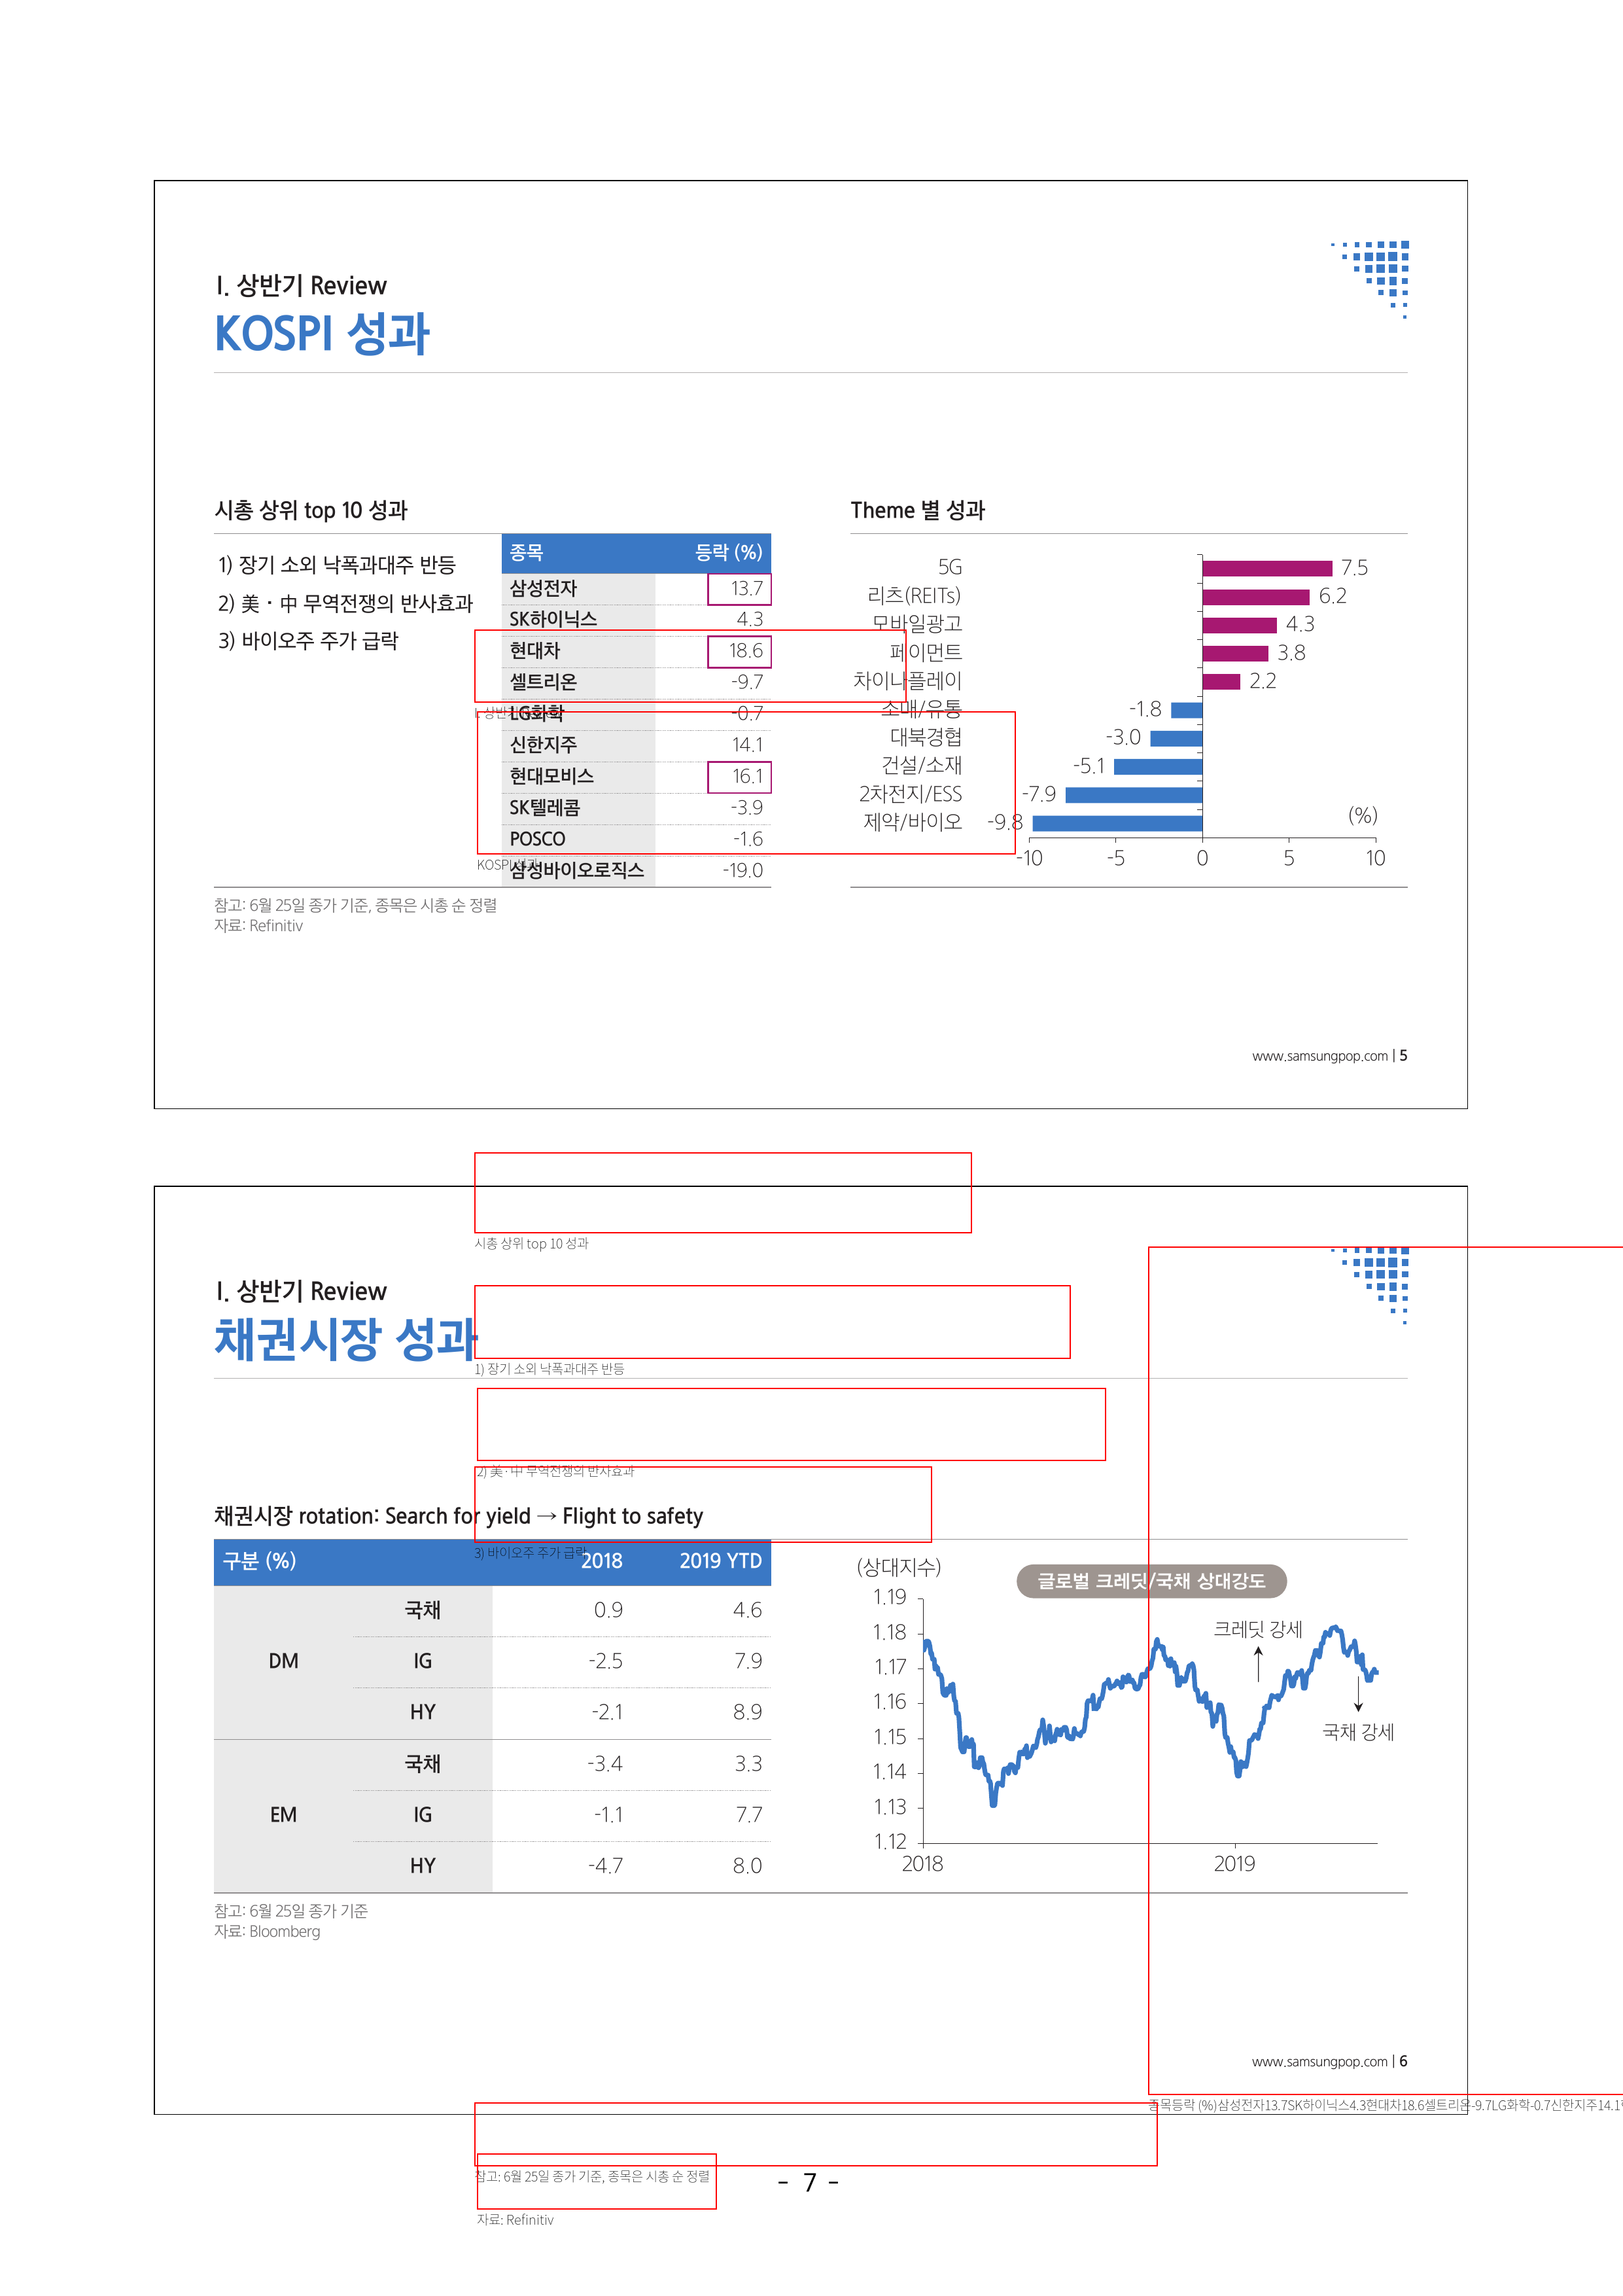

In [9]:
bbox_image